In [142]:
from owslib.wms import WebMapService
import math
from IPython.display import Image
import numpy as np


"""
Exemples:
https://geopython.github.io/OWSLib/notebooks/examples/wms.html
https://pavics-sdi.readthedocs.io/en/latest/notebooks/WMS_example.html


bounding box from distance
https://stackoverflow.com/questions/1648917/given-a-latitude-and-longitude-and-distance-i-want-to-find-a-bounding-box
"""

'\nExemples:\nhttps://geopython.github.io/OWSLib/notebooks/examples/wms.html\nhttps://pavics-sdi.readthedocs.io/en/latest/notebooks/WMS_example.html\n\n\nbounding box from distance\nhttps://stackoverflow.com/questions/1648917/given-a-latitude-and-longitude-and-distance-i-want-to-find-a-bounding-box\n'

In [143]:
url = 'https://tiles.maps.eox.at/wms?service=wms&request=getcapabilities'

wms = WebMapService(url)

In [144]:
print(f"WMS version: {wms.identification.version}")
print(f"WMS title: {wms.identification.title}")
print(f"WMS abstract: {wms.identification.abstract}")
print(f"Provider name: {wms.provider.name}")

WMS version: 1.1.1
WMS title: EOX::Maps
WMS abstract: None
Provider name: None


In [145]:
# available layers
print(list(wms.contents))

['s2cloudless-2018_3857', 'coastline', 's2cloudless-2020', 'osm_3857', 's2cloudless_3857', 'terrain_3857', 'overlay_base_bright_3857', 'hydrography', 'graticules', 'overlay_3857', 'bluemarble', 'coastline_black', 's2cloudless-2017_3857', 'streets_3857', 'overlay_bright', 's2cloudless-2019_3857', 'overlay', 'blackmarble_3857', 'hydrography_3857', 's2cloudless-2017', 'streets', 's2cloudless-2018', 's2cloudless-2019', 'osm', 'blackmarble', 'terrain-light_3857', 's2cloudless-2020_3857_512', 'bluemarble_3857', 'overlay_base_3857', 's2cloudless', 'terrain', 'overlay_bright_3857', 'coastline_3857', 's2cloudless-2020_3857', 'magnetic_graticules', 'terrain-light', 'overlay_base_bright', 'overlay_base']


In [146]:
# Contents of the layer

wms.contents['s2cloudless-2018'].boundingBox

(-180.0, -90.0, 180.0, 90.0, 'EPSG:4326')

In [147]:
wms.contents['s2cloudless-2018'].boundingBoxWGS84

(-180.0, -90.0, 180.0, 90.0)

In [148]:
print(wms['s2cloudless-2018'].crsOptions)

['EPSG:3857', 'EPSG:4326', 'EPSG:900913']


In [149]:
print(wms['s2cloudless-2018'].styles)

{}


In [150]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo']

In [151]:
wms.getOperationByName('GetMap').methods

[{'type': 'Get', 'url': 'https://tiles.maps.eox.at/?'}]

In [152]:
wms.getOperationByName('GetMap').formatOptions

['image/png', 'image/jpeg']

In [153]:
class BoundingBox(object):
    def __init__(self, *args, **kwargs):
        self.lat_min = None
        self.lon_min = None
        self.lat_max = None
        self.lon_max = None


def get_bounding_box(latitude_in_degrees, longitude_in_degrees, half_side_in_km):
    assert half_side_in_km > 0
    assert latitude_in_degrees >= -90.0 and latitude_in_degrees  <= 90.0
    assert longitude_in_degrees >= -180.0 and longitude_in_degrees <= 180.0

    lat = math.radians(latitude_in_degrees)
    lon = math.radians(longitude_in_degrees)

    radius  = 6371
    # Radius of the parallel at given latitude
    parallel_radius = radius*math.cos(lat)

    lat_min = lat - half_side_in_km/radius
    lat_max = lat + half_side_in_km/radius
    lon_min = lon - half_side_in_km/parallel_radius
    lon_max = lon + half_side_in_km/parallel_radius
    rad2deg = math.degrees

    box = BoundingBox()
    box.lat_min = rad2deg(lat_min)
    box.lon_min = rad2deg(lon_min)
    box.lat_max = rad2deg(lat_max)
    box.lon_max = rad2deg(lon_max)

    return (box)

In [154]:
# nanterre 48.903112, 2.195586
half_size_km = 3.2
bb_test = get_bounding_box(48.903112, 2.195586, half_size_km)

# 64 - 640m - 0.64km
# 6.4km - 640

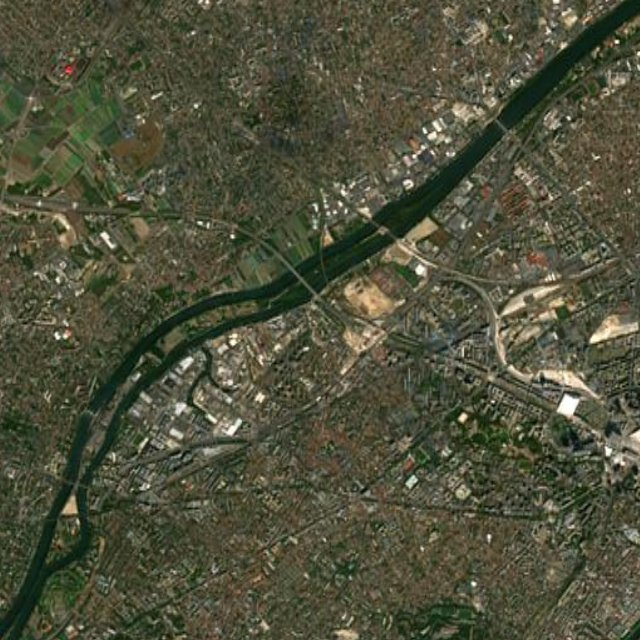

In [155]:
# Get new image
pixels = int(2 * half_size_km * 100)

response = wms.getmap(
    layers=['s2cloudless-2020'],
    size=[pixels, pixels],
    srs="EPSG:4326",
    bbox=[bb_test.lon_min, bb_test.lat_min, bb_test.lon_max, bb_test.lat_max], #Bounding box for map extent. Value is minx,miny,maxx,maxy in units of the SRS. Left, bottom, right, top
    format="image/jpeg")

img = Image(response.read())
img

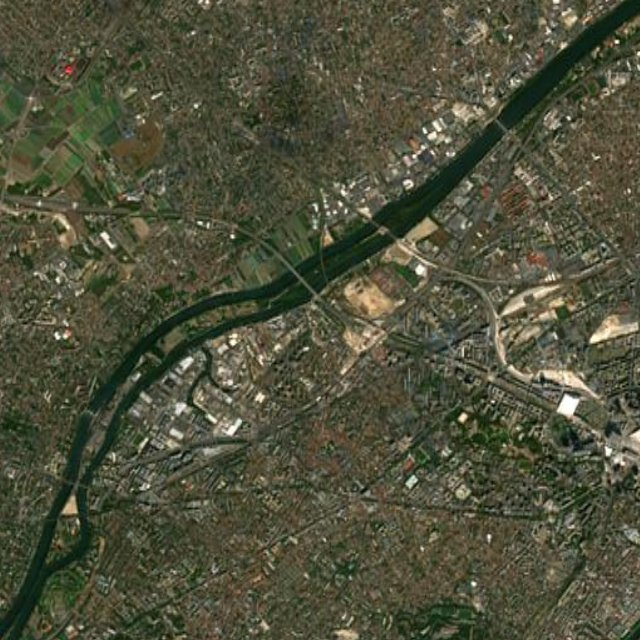

In [157]:
from io import BytesIO
import PIL

bytes_io = BytesIO(response.read())
PIL_image = PIL.Image.open(bytes_io)

PIL_image


In [159]:
# Save to PNG
# im1 = image.save("toto.jpg")

image_np = np.array(PIL_image)
display(image_np.shape)
image_np

(640, 640, 3)

array([[[ 92,  90,  67],
        [ 78,  76,  53],
        [ 77,  75,  52],
        ...,
        [ 14,  38,  22],
        [ 13,  38,  19],
        [ 12,  37,  18]],

       [[109, 107,  84],
        [ 95,  93,  70],
        [ 92,  90,  67],
        ...,
        [ 14,  38,  22],
        [ 15,  40,  21],
        [ 14,  39,  20]],

       [[121, 119,  96],
        [111, 109,  86],
        [107, 105,  82],
        ...,
        [ 14,  38,  22],
        [ 15,  39,  23],
        [ 16,  40,  24]],

       ...,

       [[ 26,  28,   7],
        [ 32,  35,  14],
        [ 49,  54,  32],
        ...,
        [  6,  16,   5],
        [ 14,  26,  12],
        [ 29,  46,  30]],

       [[ 31,  31,   7],
        [ 50,  50,  26],
        [ 65,  69,  46],
        ...,
        [ 19,  27,  16],
        [ 31,  42,  28],
        [ 48,  62,  47]],

       [[ 39,  37,  12],
        [ 62,  62,  36],
        [ 72,  74,  50],
        ...,
        [ 33,  39,  29],
        [ 47,  58,  44],
        [ 63,  75,  61]]